In [1]:
# imports
import lxml.html as lh
import pandas as pd
from bs4 import BeautifulSoup
import json
import requests
import matplotlib.pyplot as plt
from functools import reduce


%matplotlib inline

In [2]:
race_json = []
with open('ultrasignup/races.txt', 'r') as f:
    for line in f:
        line = line[:-2]
        race_json.append(line[line.rfind('=')+1:])

In [3]:
race_json = list(dict.fromkeys(race_json)) # remove duplicates

In [4]:
# base url
url = 'http://ultrasignup.com/service/events.svc/results/{}/json?_search=false'

count = 0
df_list = []

# grab the data
for i in race_json:
    try:
        page = requests.get(url.format(i))
        results = page.json()
    except json.JSONDecodeError:
        continue
    # create df from JSON
    globals()['df' + str(count)] = pd.DataFrame.from_records(results)
    if len(globals()['df' + str(count)]) > 3: # arbitrary number but ensures no empty df comes in
        df_list.append(globals()['df' + str(count)])
    count += 1
# combine dfs into a final df 
df = reduce(lambda left,right: pd.merge(left,right,how='outer'), df_list)
len(df_list) # number of races scraped that had JSON

189

In [5]:
irrelevant = ['age_rank','photo_count','prior_count','race_count', 'drilldown',
              'time', 'status','bib', 'agegroup', 'participant_id'] # do not need these 
for col in df.columns:
    if col in irrelevant:
        del df[col]

df = df[df.age != 0] # does not contribute
df = df[df.state != ''] # does not contribute
df.head()

,age,city,firstname,formattime,gender,gender_place,lastname,place,runner_rank,state
3,32,Alamo,Kevin,21:28:00,M,4,Sawchuk,4,89.99,CA
94,58,Oakland,Errol,33:04:00,M,82,Jones,95,73.79,CA
96,43,Austin,Joe,33:04:00,M,84,Prusaitis,97,65.27,TX
119,33,Goleta,John,34:27:00,M,103,Hoenigman,120,66.63,CA
152,22,Los Alamos,Kyle,19:35:14,M,1,Skaggs,1,99.44,NM


In [6]:
len(df) # number of participants

6809

In [8]:
# lists to create various dataframe
states = []
ages = []
num_part = []


# create empty dataframes
age_df = pd.DataFrame(columns=['state', 'avg_age'])
part_df = pd.DataFrame(columns=['state', 'participants'])

# iterate through each state
for state in df.state.unique():
    # find the average age and number of participants
    if df['state'].value_counts()[state] > 25:
        sum_age = df.loc[df['state'] == state, 'age'].sum()
        num_part.append(df['state'].value_counts()[state])
        avg_age = "{0:.2f}".format(sum_age / df['state'].value_counts()[state])
        states.append(state)
        ages.append(float(avg_age))
        
    else:
        df = df[df['state'] != state] # remove the small num of states
        
df.age.astype(int)
# populate the dataframes
age_df['state'] = states
age_df['avg_age'] = ages
part_df['state'] = states
part_df['participants'] = num_part
age_df.head()

,state,avg_age
0,CA,40.86
1,TX,41.93
2,NM,44.66
3,CO,42.34
4,OR,42.35


In [9]:
 # states with only one participant dont add much
part_df.head(100)

,state,participants
0,CA,4177
1,TX,83
2,NM,92
3,CO,168
4,OR,452
5,VA,51
6,UT,128
7,ID,33
8,WA,230
9,NY,56


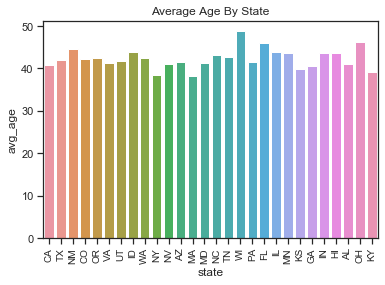

In [10]:
import seaborn as sns # visualize avg age
sns.set(style="ticks", color_codes=True)

plt.xticks(rotation=90,fontsize=10) # due this to avoid crowding
plt.title('Average Age By State')
sns.barplot(x='state', y='avg_age',data=age_df) # TODO visualize this better



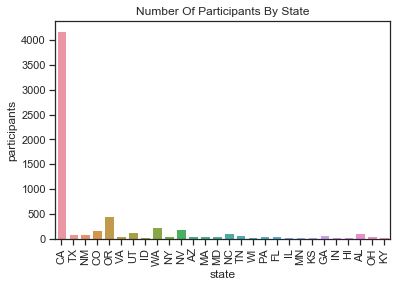

In [11]:
plt.xticks(rotation=90)
plt.title('Number Of Participants By State')
sns.barplot(x='state', y='participants',data=part_df)

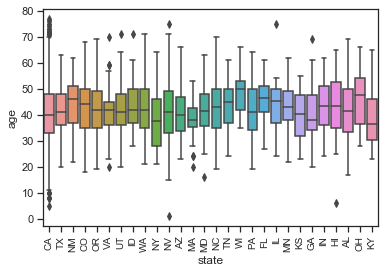

In [12]:
plt.xticks(rotation=90,fontsize=10)
sns.boxplot(x='state', y='age', data=df) # TODO clean this up a bit